In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

from ortools.graph.python import min_cost_flow

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        #print('PE',self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    
    
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch,d_batch = [], [], [], []
    for j in range(batch_len):
        
        if train:
            E1,E2,A,D=loadgraph()
        elif recon:
            E1,E2,A,D=loadgraph(recon=True, train=False,run=run,t_r=j)
            print('recon')
        else:
            E1,E2,A,D=loadgraph(train=False)
        #print('src_sample',src_sample)
        src1_batch.append(E1)
        #print('emb',src_batch[-1])
        src2_batch.append(E2)
        y_batch.append(A)
        d_batch.append(D)
        
        
    #print('src_batch',src_batch)
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=PAD_IDX)
    
    
    #print('src1',src1_batch[:,0,:])
    #print('y',y_batch)
    ##
    return src1_batch, src2_batch,y_batch,d_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,11)
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        #print('E',E.shape)
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        #print(bg_a)
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        #print(D)
        #print(np.dot(E1,E2.T))
        
        
        
        
    else:
        #print('eval')
        if run==None:
            run=np.random.randint(11,15)
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        #print(A)
        
        D=D[id1-1]
        D=D[:,id2-1]
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        
    if recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        #print(A)
        
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
       
        #print(E1,E2)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
    
    
    
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
    
    
    if easy:
        n1=np.random.randint(3,6)
        n2=n1+np.random.randint(2)
        E1=np.ones((n1,6))
        E2=np.ones((n2,6))*3
        A=np.ones((n1,n2))
    
    
    
   
    
    D=D.astype(np.float32)
    
    vd = np.vectorize(d_mask_function,otypes=[float])
    
    D = vd(D,0.15,-2.0)
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A)
    D=convert_tensor(D)
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0],D[0]

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask


def train_easy(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    model.train()
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        print(i)
        
        #u = np.random.random_integers(4998) #4998 for 3_GT
        src1, src2, y = collate_fn(10,-100)
        
        #print('src_batch',src1)
        #print('src_batch s',src1.size())
        
        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        
        
        output1,output2 = model(src1,src2,src_padding_mask1,src_padding_mask2)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        #print('out1',output1,output1.size())
        #print('out2',output2,output2.size())
        
        

 
        #print('train_sizes',src.size(),output[:,:n_nodes,:n_nodes].size(),y.size())
        
        
        epoch_loss = loss_function(output1, src1)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        i=i+1
        
        '''
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(easy=True)
                
                n_nodes=0
                for h in range(len(src_t[0])):
                    if torch.sum(src_t[0][h])!=0:
                        n_nodes=n_nodes+1
                
                max_len=len(src_t[0])
                
                output_t = model(src_t,tgt_t,n_nodes)

                test_loss = loss_function(output_t[:,:n_nodes,:n_nodes], y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error
    '''
        
        
class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad
    
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    #print(Ad[0],y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)


def train_epoch_post_process(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)
    
    Ad = complete_postprocess(Ad,d,0.01)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    print(Ad[0])
    print(y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)



class Loss():
    def __init__(self,pen,tra_to_tens=False):
        self.pen=pen
        self.trans=tra_to_tens
        
    def loss (self,Ad,y):
        convert_tensor = transforms.ToTensor()
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            if self.trans:
                Ad[i]=convert_tensor(Ad[i])[0]
            #print(Ad[i], y[i])
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        if self.trans:
            loss = Variable(loss, requires_grad = True)
        return loss
    


def evaluate(model,loss_fn):
    model.eval()
    losses = 0

    src1, src2, y,d = collate_fn(31,-100,train=False)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)


def postprocess(A):
    pp_A=[]
    for i in range(len(A)):
        ind=torch.argmax(A[i], dim=0)
        B=np.zeros(A[i].shape)
        for j in range(len(ind)):
            B[ind[j],j]=1
        pp_A.append(B)
    return pp_A

def square(m):
    return m.shape[0] == m.shape[1]


def postprocess_2(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2)  
        
    return pp_A



def postprocess_3(Ad):
    pp_A=[]
    
    row_ind, col_ind = linear_sum_assignment(1-Ad[0])
    
    print(1-Ad[0])
    print(row_ind, col_ind)
    
    z=np.zeros(Ad[0].shape)


    for i,j in zip(row_ind, col_ind):
        z[i,j]=1
    
    
    print(z)
    '''
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h])

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2) 
    '''
        
    return pp_A








def postprocess_linAss(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
        else:
            f=Ad[h].detach().numpy()
            l=np.ones(len(f))*2
            l=l.astype(int)
            
            
            f2=np.repeat(f, l, axis=0)
            row_ind, col_ind = linear_sum_assignment(1-f)
            z=np.zeros(f.shape)
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1

            f2[0::2, :] = z[:] 

            row_ind_f, col_ind_f = linear_sum_assignment(1-f2)


            z3=np.zeros(f2.shape)


            for i,j in zip(row_ind_f, col_ind_f):
                z3[i,j]=1

            f_add = z3[0::2, :] + z3[1::2, :]
            
            pp_A.append(f_add)

        
    return pp_A





def postprocess_MinCostAss(Ad,a):
    pp_A=[]
    for h in range(len(Ad)):
        smcf = min_cost_flow.SimpleMinCostFlow()
        c_A = Ad[h]
        
        #left_n=c_A.size(0)
        #right_n=c_A.size(1)
        
        left_n=c_A.shape[0]
        right_n=c_A.shape[1]
        
        
        st=np.zeros(left_n)
        con= np.ones(right_n) 
        for v in range(left_n-1):
            con= np.append(con, np.ones(right_n)*(v+2))
        #print('con',con) 
        si = np.arange(left_n+1,left_n+right_n+1)
        start_nodes = np.concatenate((st,np.array(con),si))
        start_nodes = np.append(start_nodes,0)
        start_nodes = [int(x) for x in start_nodes ]
        #print(start_nodes)
        
        st_e = np.arange(1,left_n+1)
        con_e = si
        for j in range(left_n-1):
            con_e = np.append(con_e,si)
            
        si_e = np.ones(right_n)*left_n+right_n+1
        
        end_nodes = np.concatenate((st_e,np.array(con_e),si_e))
        end_nodes = np.append(end_nodes,si_e[-1])
        end_nodes = [int(x) for x in end_nodes ]
        #print(end_nodes)
        
        
        tasks = np.max([right_n,left_n])
        
        cap_0 = np.ones(left_n)
        cap_0[0]=right_n-1
        
        cap_left=np.ones(right_n)
        cap_left[0]=right_n
        
        capacities = np.concatenate((cap_0,np.ones(len(con_e)),cap_left))
        capacities = np.append(capacities,tasks)
        capacities = [int(x) for x in capacities]
        #print(capacities)
        
        '''
        c_A[0]=c_A[0]/c_A[0,0]
        c_A[0]=c_A[0]/(1.01*np.max(c_A[0]))
        c_A[:,0]=c_A[:,0]/c_A[0,0]
        c_A[:,0]=c_A[:,0]/(1.01*np.max(c_A[:,0]))
        '''
        
        #print(c_A)
        c= c_A.flatten()                          
        #c=torch.flatten(c_A)
        #c=c.detach().numpy()  
                                    
                                    
        c=(1-c)*10**4
        
        #print(c)
                                    
        costs = np.concatenate((np.zeros(left_n),c,np.zeros(right_n)))
        costs = np.append(costs,a*np.mean(c))                            
        costs = [int(x) for x in costs]
                                    
        #print(costs)
        
        source = 0
        sink = left_n+right_n+1
        
        supplies= tasks 
        
        supplies=np.append(supplies,np.ones(left_n))
        supplies=np.append(supplies,np.zeros(right_n))
        
        #supplies=np.append(supplies,np.zeros(left_n+right_n))
        
        supplies=np.append(supplies,-(tasks+left_n))
        
        supplies = [int(x) for x in supplies]
        #print(supplies)
        #print('____________________________________')
        # Add each arc.
        for i in range(len(start_nodes)):
            #print(start_nodes[i], end_nodes[i],capacities[i], costs[i])
            smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
        # Add node supplies.
        for i in range(len(supplies)):
            smcf.set_node_supply(i, supplies[i])

        # Find the minimum cost flow between node 0 and node 10.
        status = smcf.solve()

        if status == smcf.OPTIMAL:
            #print('Total cost = ', smcf.optimal_cost())
            #print()
            row_ind=[]
            col_ind=[]
            for arc in range(smcf.num_arcs()):
                # Can ignore arcs leading out of source or into sink.
                if smcf.tail(arc) != source and smcf.head(arc) != sink:

                    # Arcs in the solution have a flow value of 1. Their start and end nodes
                    # give an assignment of worker to task.
                    if smcf.flow(arc) > 0:
                        #p#rint('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                        #      (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                        row_ind.append(smcf.tail(arc)-1)
                        col_ind.append(smcf.head(arc)-left_n-1)
            z=np.zeros((left_n,right_n))
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1
             
            
            #print('z_orig',z)
            s=np.sum(z,axis=1)
            for e in range(len(s)):
                if s[e]>1 and e!=0:
                    z[e,0]=0
            #print('z_bg_cor',z)      
            if (~z.any(axis=0)).any():
                z_col_ind=np.where(~z.any(axis=0))[0]
                z[:,z_col_ind]=c_A[:,z_col_ind]
                #print('---------z_0_col',z)
                z=postprocess_MinCostAss(np.array([z]),2*a)[0]
                #print('z_0_col_after',z)

                    
            pp_A.append(z)
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
        else:
            print('There was an issue with the min cost flow input.')
            print(f'Status: {status}')
          



    return pp_A

        
'''

    start_nodes = np.zeros(c_A.size(0)) + [
        1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3
    ] + [4, 5, 6, 7]
    end_nodes = [1, 2, 3] + [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7] + [8,8,8,8]
    capacities = [2, 2, 2] + [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
    ] + [2, 2, 2, 2]
    costs = (
        [0, 0, 0] +
        c +
        [0, 0, 0 ,0])

    source = 0
    sink = 8
    tasks = 4
    supplies = [tasks, 0, 0, 0, 0, 0, 0, 0, -tasks]

    # Add each arc.
    for i in range(len(start_nodes)):
        smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        smcf.set_node_supply(i, supplies[i])

    # Find the minimum cost flow between node 0 and node 10.
    status = smcf.solve()

    if status == smcf.OPTIMAL:
        print('Total cost = ', smcf.optimal_cost())
        print()
        for arc in range(smcf.num_arcs()):
            # Can ignore arcs leading out of source or into sink.
            if smcf.tail(arc) != source and smcf.head(arc) != sink:

                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if smcf.flow(arc) > 0:
                    print('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                          (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')
            pp_A.append(f_add)

        
    return pp_A

'''

def make_reconstructed_edgelist(A,run):
    
    e_start=[1,2,3]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        
        
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                if M[z,j]!=0:
                    print(z,e_start)
                    e1.append(int(e_start[z]))
                    e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                    print('e',e_mid)
                    e2.append(int(e_mid[j]))
        
        e_start=e_mid
        print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0

def d_mask_function(x,r_core,alpha):
    if x < r_core:
        return 1
    else:
        return (x/r_core)**alpha
    
    
def complete_postprocess(Ad,d,a):
    
    m_Ad = []
    
    for h in range(len(Ad)):
        m_Ad.append(np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy()))
        
   




    Ad = postprocess_MinCostAss(m_Ad,a)
    #Ad=postprocess_MinCostAss(Ad)



    return Ad

    

In [3]:
a = np.array([[1, 2], [3, 4]])
print(a)

b = np.array([[5, 6]])

np.concatenate((a, b), axis=0)


np.concatenate((a, b.T), axis=1)



loadgraph(run=1)

#print(stop)

[[1 2]
 [3 4]]


(tensor([[-1.2807e-01,  3.0562e-01,  2.0760e-01, -1.7747e-03, -1.3750e-02,
           3.2800e-01, -8.7021e-02,  3.1828e-01,  1.5465e-01, -2.2020e-01,
          -3.6121e-02, -1.6164e-01, -1.0786e-03,  1.0764e-01, -1.0832e-01,
          -7.2255e-02,  1.1957e-01,  2.6193e-01,  1.7913e-01, -1.5523e-01,
           1.2118e-01, -3.3428e-02,  4.4078e-01, -1.3274e-01],
         [-1.7256e-01,  4.5568e-01,  4.1504e-01, -3.6570e-01, -1.7112e-01,
           9.8983e-01,  1.9030e-01,  5.1654e-02,  5.7555e-01, -7.0587e-02,
          -1.0929e-03,  3.3421e-02,  9.1806e-01, -9.3121e-02,  1.6938e-01,
          -7.9876e-01, -3.7830e-01,  3.3221e-01,  3.7419e-01,  5.7635e-02,
          -1.1850e-01,  5.1035e-01,  6.1478e-01,  2.1100e-01],
         [ 3.7732e-01,  4.8747e-01,  6.5124e-01,  1.7428e-01,  2.2978e-01,
          -2.8965e-01,  8.2040e-02,  9.6765e-01,  6.5756e-01, -6.8698e-01,
           1.6752e-01,  5.6509e-02, -1.8575e-01,  5.0929e-01, -1.8768e-01,
          -1.3539e-01,  4.7326e-02,  4.8272e-01, 

In [4]:
class AdjacencyTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(AdjacencyTransformer, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        
        #self.lin = nn.Sequential(
        #    nn.Linear(input_dim, emb_size),
        #    nn.LeakyReLU())
        
        #self.lin2 = nn.Sequential(
        #    nn.Linear(emb_size, emb_size),
        #    nn.LeakyReLU())

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
        #print('trans_src_before_pos',src_t1,src_t1.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        #src_t1 = self.lin(src_t1)
        #src_t2 = self.lin(src_t2)
        
        #src_t1 = self.lin2(src_t1)
        #src_t2 = self.lin2(src_t2)
        
        src1_emb = self.positional_encoding(src_t1)
        src2_emb = self.positional_encoding(src_t2)
        #print('trans_src',src1_emb,src1_emb.size())
        #print('trans_src_padd',src_padding_mask1,src_padding_mask1.size())
        out1 = self.encoder(src1_emb,src_key_padding_mask=src_padding_mask1)
        out2 = self.encoder(src2_emb,src_key_padding_mask=src_padding_mask2)
        
        out_dec1=self.decoder(out2, out1,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        
        #out_dec2=self.decoder(out1, out2,tgt_key_padding_mask=src_padding_mask1,memory_key_padding_mask=src_padding_mask2)
        out_dec2=out1
        #out1=torch.transpose(out1,0,1)
        #out2=torch.transpose(out2,0,1)
        #out2=torch.transpose(out2,1,2)
        
        #z=self.sig(torch.bmm(out1,out2))
        
        out_dec2=torch.transpose(out_dec2,0,1)
        out_dec1=torch.transpose(out_dec1,0,1)
        out_dec1=torch.transpose(out_dec1,1,2)
        
        z=self.sig(torch.bmm(out_dec2,out_dec1))
        
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        return Ad
    
    
    
    
    
    
    
    
class AdjacencyNonlearn(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(AdjacencyNonlearn, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        
        #self.lin = nn.Sequential(
        #    nn.Linear(input_dim, emb_size),
        #    nn.LeakyReLU())
        
        #self.lin2 = nn.Sequential(
        #    nn.Linear(emb_size, emb_size),
        #    nn.LeakyReLU())

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
      
        
        out_dec2=torch.transpose(src_t1,0,1) 
        out_dec1=torch.transpose(src_t2,0,1)
        out_dec1=torch.transpose(out_dec1,1,2)
        
        z=self.sig(torch.bmm(out_dec2,out_dec1))
        
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        return Ad
    

In [5]:
input_dim=3

emb_size= 24 ###!!!!24 for n2v emb
nhead= 6    ####!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [6]:
from timeit import default_timer as timer
NUM_EPOCHS = 4000

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_xyr.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss_xyr.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')


Epoch: 1, Train loss: 4.435, Val loss: 3.796, Epoch time = 2.568s
Epoch: 2, Train loss: 4.266, Val loss: 4.683, Epoch time = 2.698s
Epoch: 3, Train loss: 4.542, Val loss: 4.252, Epoch time = 2.814s
Epoch: 4, Train loss: 3.635, Val loss: 3.745, Epoch time = 2.772s
Epoch: 5, Train loss: 4.691, Val loss: 3.644, Epoch time = 2.799s
Epoch: 6, Train loss: 4.226, Val loss: 3.668, Epoch time = 2.713s
Epoch: 7, Train loss: 4.735, Val loss: 3.860, Epoch time = 2.683s
Epoch: 8, Train loss: 3.640, Val loss: 3.789, Epoch time = 2.758s
Epoch: 9, Train loss: 3.767, Val loss: 3.722, Epoch time = 2.565s
Epoch: 10, Train loss: 4.196, Val loss: 4.893, Epoch time = 2.512s
Epoch: 11, Train loss: 4.814, Val loss: 4.754, Epoch time = 2.550s
Epoch: 12, Train loss: 4.011, Val loss: 4.481, Epoch time = 2.576s
Epoch: 13, Train loss: 4.483, Val loss: 3.719, Epoch time = 2.706s
Epoch: 14, Train loss: 4.255, Val loss: 3.521, Epoch time = 2.840s
Epoch: 15, Train loss: 4.034, Val loss: 3.655, Epoch time = 2.398s
Epoc

Epoch: 124, Train loss: 4.453, Val loss: 3.016, Epoch time = 2.545s
Epoch: 125, Train loss: 3.941, Val loss: 3.570, Epoch time = 2.714s
Epoch: 126, Train loss: 4.263, Val loss: 3.375, Epoch time = 2.499s
Epoch: 127, Train loss: 4.836, Val loss: 3.404, Epoch time = 2.437s
Epoch: 128, Train loss: 4.461, Val loss: 3.330, Epoch time = 2.644s
Epoch: 129, Train loss: 4.048, Val loss: 3.501, Epoch time = 2.537s
Epoch: 130, Train loss: 4.518, Val loss: 4.067, Epoch time = 2.457s
Epoch: 131, Train loss: 4.031, Val loss: 4.219, Epoch time = 2.529s
Epoch: 132, Train loss: 4.721, Val loss: 3.755, Epoch time = 2.545s
Epoch: 133, Train loss: 4.563, Val loss: 3.574, Epoch time = 2.535s
Epoch: 134, Train loss: 4.077, Val loss: 3.368, Epoch time = 2.425s
Epoch: 135, Train loss: 4.304, Val loss: 3.465, Epoch time = 2.443s
Epoch: 136, Train loss: 4.498, Val loss: 3.576, Epoch time = 2.469s
Epoch: 137, Train loss: 3.464, Val loss: 3.214, Epoch time = 2.639s
Epoch: 138, Train loss: 4.570, Val loss: 3.576, 

Epoch: 245, Train loss: 4.435, Val loss: 3.476, Epoch time = 2.477s
Epoch: 246, Train loss: 3.937, Val loss: 3.644, Epoch time = 2.587s
Epoch: 247, Train loss: 4.199, Val loss: 2.959, Epoch time = 2.593s
Epoch: 248, Train loss: 3.588, Val loss: 3.248, Epoch time = 2.492s
Epoch: 249, Train loss: 3.470, Val loss: 3.347, Epoch time = 2.480s
Epoch: 250, Train loss: 3.329, Val loss: 3.918, Epoch time = 2.566s
Epoch: 251, Train loss: 3.600, Val loss: 3.219, Epoch time = 2.576s
Epoch: 252, Train loss: 3.792, Val loss: 3.205, Epoch time = 2.441s
Epoch: 253, Train loss: 3.812, Val loss: 3.437, Epoch time = 2.566s
Epoch: 254, Train loss: 3.740, Val loss: 3.461, Epoch time = 2.455s
Epoch: 255, Train loss: 4.049, Val loss: 3.006, Epoch time = 2.385s
Epoch: 256, Train loss: 3.334, Val loss: 3.543, Epoch time = 2.458s
Epoch: 257, Train loss: 3.896, Val loss: 3.695, Epoch time = 2.563s
Epoch: 258, Train loss: 3.689, Val loss: 3.378, Epoch time = 2.439s
Epoch: 259, Train loss: 3.918, Val loss: 3.660, 

Epoch: 366, Train loss: 3.647, Val loss: 3.041, Epoch time = 2.606s
Epoch: 367, Train loss: 3.702, Val loss: 3.965, Epoch time = 2.573s
Epoch: 368, Train loss: 3.742, Val loss: 2.939, Epoch time = 2.546s
Epoch: 369, Train loss: 4.415, Val loss: 3.363, Epoch time = 2.507s
Epoch: 370, Train loss: 3.502, Val loss: 2.955, Epoch time = 2.603s
Epoch: 371, Train loss: 4.182, Val loss: 3.050, Epoch time = 2.548s
Epoch: 372, Train loss: 3.577, Val loss: 3.255, Epoch time = 2.566s
Epoch: 373, Train loss: 3.262, Val loss: 3.152, Epoch time = 2.428s
Epoch: 374, Train loss: 3.172, Val loss: 3.640, Epoch time = 2.612s
Epoch: 375, Train loss: 4.328, Val loss: 3.277, Epoch time = 2.600s
Epoch: 376, Train loss: 3.604, Val loss: 2.975, Epoch time = 2.621s
Epoch: 377, Train loss: 3.723, Val loss: 3.307, Epoch time = 2.591s
Epoch: 378, Train loss: 3.318, Val loss: 3.152, Epoch time = 2.720s
Epoch: 379, Train loss: 4.108, Val loss: 3.520, Epoch time = 2.440s
Epoch: 380, Train loss: 3.893, Val loss: 3.263, 

Epoch: 487, Train loss: 3.922, Val loss: 3.329, Epoch time = 2.621s
Epoch: 488, Train loss: 4.390, Val loss: 3.029, Epoch time = 2.535s
Epoch: 489, Train loss: 3.521, Val loss: 3.069, Epoch time = 2.519s
Epoch: 490, Train loss: 3.973, Val loss: 3.024, Epoch time = 2.610s
Epoch: 491, Train loss: 3.707, Val loss: 2.843, Epoch time = 2.438s
Epoch: 492, Train loss: 3.676, Val loss: 2.895, Epoch time = 2.449s
Epoch: 493, Train loss: 3.625, Val loss: 2.913, Epoch time = 2.490s
Epoch: 494, Train loss: 3.597, Val loss: 3.395, Epoch time = 2.709s
Epoch: 495, Train loss: 3.548, Val loss: 3.163, Epoch time = 2.587s
Epoch: 496, Train loss: 3.689, Val loss: 2.809, Epoch time = 2.602s
Epoch: 497, Train loss: 3.447, Val loss: 3.169, Epoch time = 2.589s
Epoch: 498, Train loss: 3.410, Val loss: 3.268, Epoch time = 2.442s
Epoch: 499, Train loss: 3.993, Val loss: 3.165, Epoch time = 2.538s
Epoch: 500, Train loss: 3.861, Val loss: 3.286, Epoch time = 2.505s
Epoch: 501, Train loss: 3.348, Val loss: 2.906, 

Epoch: 608, Train loss: 3.780, Val loss: 2.972, Epoch time = 2.469s
Epoch: 609, Train loss: 3.916, Val loss: 3.285, Epoch time = 2.478s
Epoch: 610, Train loss: 4.284, Val loss: 3.112, Epoch time = 2.482s
Epoch: 611, Train loss: 3.366, Val loss: 2.989, Epoch time = 2.541s
Epoch: 612, Train loss: 3.621, Val loss: 2.449, Epoch time = 2.519s
Epoch: 613, Train loss: 3.750, Val loss: 2.598, Epoch time = 2.728s
Epoch: 614, Train loss: 3.247, Val loss: 3.123, Epoch time = 2.627s
Epoch: 615, Train loss: 3.361, Val loss: 3.444, Epoch time = 2.523s
Epoch: 616, Train loss: 3.176, Val loss: 3.922, Epoch time = 2.478s
Epoch: 617, Train loss: 3.581, Val loss: 2.928, Epoch time = 2.460s
Epoch: 618, Train loss: 4.088, Val loss: 2.904, Epoch time = 2.606s
Epoch: 619, Train loss: 3.907, Val loss: 3.065, Epoch time = 2.429s
Epoch: 620, Train loss: 3.936, Val loss: 2.984, Epoch time = 2.629s
Epoch: 621, Train loss: 3.743, Val loss: 3.215, Epoch time = 2.645s
Epoch: 622, Train loss: 4.433, Val loss: 2.817, 

Epoch: 729, Train loss: 3.305, Val loss: 2.957, Epoch time = 2.669s
Epoch: 730, Train loss: 3.637, Val loss: 2.818, Epoch time = 2.629s
Epoch: 731, Train loss: 3.357, Val loss: 2.742, Epoch time = 2.598s
Epoch: 732, Train loss: 3.933, Val loss: 2.774, Epoch time = 2.530s
Epoch: 733, Train loss: 3.179, Val loss: 3.212, Epoch time = 2.760s
Epoch: 734, Train loss: 3.571, Val loss: 3.036, Epoch time = 2.500s
Epoch: 735, Train loss: 3.590, Val loss: 3.233, Epoch time = 2.637s
Epoch: 736, Train loss: 4.283, Val loss: 2.806, Epoch time = 2.525s
Epoch: 737, Train loss: 3.937, Val loss: 3.231, Epoch time = 2.564s
Epoch: 738, Train loss: 3.607, Val loss: 2.888, Epoch time = 2.585s
Epoch: 739, Train loss: 3.462, Val loss: 3.342, Epoch time = 2.711s
Epoch: 740, Train loss: 4.354, Val loss: 2.792, Epoch time = 2.686s
Epoch: 741, Train loss: 3.938, Val loss: 2.927, Epoch time = 2.766s
Epoch: 742, Train loss: 3.117, Val loss: 2.964, Epoch time = 2.627s
Epoch: 743, Train loss: 3.684, Val loss: 4.098, 

Epoch: 850, Train loss: 3.175, Val loss: 2.736, Epoch time = 2.466s
Epoch: 851, Train loss: 4.522, Val loss: 3.053, Epoch time = 2.679s
Epoch: 852, Train loss: 4.076, Val loss: 3.133, Epoch time = 2.477s
Epoch: 853, Train loss: 3.702, Val loss: 3.013, Epoch time = 2.562s
Epoch: 854, Train loss: 3.389, Val loss: 3.530, Epoch time = 2.593s
Epoch: 855, Train loss: 3.588, Val loss: 2.759, Epoch time = 2.505s
Epoch: 856, Train loss: 3.428, Val loss: 3.940, Epoch time = 2.600s
Epoch: 857, Train loss: 2.870, Val loss: 3.121, Epoch time = 2.577s
Epoch: 858, Train loss: 3.593, Val loss: 2.801, Epoch time = 2.667s
Epoch: 859, Train loss: 3.327, Val loss: 3.286, Epoch time = 2.537s
Epoch: 860, Train loss: 3.498, Val loss: 2.968, Epoch time = 2.766s
Epoch: 861, Train loss: 3.594, Val loss: 3.036, Epoch time = 2.539s
Epoch: 862, Train loss: 3.796, Val loss: 2.920, Epoch time = 2.501s
Epoch: 863, Train loss: 4.528, Val loss: 3.913, Epoch time = 2.475s
Epoch: 864, Train loss: 3.580, Val loss: 2.944, 

Epoch: 971, Train loss: 3.202, Val loss: 2.722, Epoch time = 2.657s
Epoch: 972, Train loss: 4.197, Val loss: 2.858, Epoch time = 2.446s
Epoch: 973, Train loss: 3.177, Val loss: 2.640, Epoch time = 2.585s
Epoch: 974, Train loss: 4.312, Val loss: 2.750, Epoch time = 2.567s
Epoch: 975, Train loss: 3.607, Val loss: 2.992, Epoch time = 2.477s
Epoch: 976, Train loss: 2.953, Val loss: 2.897, Epoch time = 2.389s
Epoch: 977, Train loss: 3.129, Val loss: 2.939, Epoch time = 2.523s
Epoch: 978, Train loss: 3.404, Val loss: 2.772, Epoch time = 2.562s
Epoch: 979, Train loss: 2.741, Val loss: 2.717, Epoch time = 2.668s
Epoch: 980, Train loss: 2.994, Val loss: 2.917, Epoch time = 2.627s
Epoch: 981, Train loss: 3.375, Val loss: 3.359, Epoch time = 2.598s
Epoch: 982, Train loss: 3.921, Val loss: 2.753, Epoch time = 2.567s
Epoch: 983, Train loss: 3.567, Val loss: 2.862, Epoch time = 2.504s
Epoch: 984, Train loss: 3.458, Val loss: 3.029, Epoch time = 2.586s
Epoch: 985, Train loss: 4.068, Val loss: 2.731, 

Epoch: 1091, Train loss: 3.247, Val loss: 2.719, Epoch time = 2.597s
Epoch: 1092, Train loss: 3.407, Val loss: 2.983, Epoch time = 2.584s
Epoch: 1093, Train loss: 3.152, Val loss: 3.509, Epoch time = 2.499s
Epoch: 1094, Train loss: 3.602, Val loss: 3.117, Epoch time = 2.581s
Epoch: 1095, Train loss: 3.328, Val loss: 2.718, Epoch time = 2.628s
Epoch: 1096, Train loss: 3.956, Val loss: 3.135, Epoch time = 2.490s
Epoch: 1097, Train loss: 3.242, Val loss: 3.158, Epoch time = 2.597s
Epoch: 1098, Train loss: 3.292, Val loss: 2.755, Epoch time = 2.540s
Epoch: 1099, Train loss: 3.605, Val loss: 2.863, Epoch time = 2.523s
Epoch: 1100, Train loss: 3.089, Val loss: 2.857, Epoch time = 2.524s
Epoch: 1101, Train loss: 3.105, Val loss: 2.941, Epoch time = 2.485s
Epoch: 1102, Train loss: 3.191, Val loss: 3.505, Epoch time = 2.645s
Epoch: 1103, Train loss: 3.430, Val loss: 2.788, Epoch time = 2.550s
Epoch: 1104, Train loss: 3.308, Val loss: 3.003, Epoch time = 2.496s
Epoch: 1105, Train loss: 3.906, Va

Epoch: 1210, Train loss: 3.383, Val loss: 3.069, Epoch time = 2.487s
Epoch: 1211, Train loss: 3.916, Val loss: 2.304, Epoch time = 2.585s
Epoch: 1212, Train loss: 3.279, Val loss: 2.907, Epoch time = 2.457s
Epoch: 1213, Train loss: 3.274, Val loss: 2.780, Epoch time = 2.474s
Epoch: 1214, Train loss: 3.159, Val loss: 3.021, Epoch time = 2.495s
Epoch: 1215, Train loss: 3.407, Val loss: 2.694, Epoch time = 2.645s
Epoch: 1216, Train loss: 3.938, Val loss: 2.622, Epoch time = 2.471s
Epoch: 1217, Train loss: 3.899, Val loss: 2.966, Epoch time = 2.493s
Epoch: 1218, Train loss: 3.219, Val loss: 2.944, Epoch time = 2.592s
Epoch: 1219, Train loss: 3.842, Val loss: 2.912, Epoch time = 2.729s
Epoch: 1220, Train loss: 3.377, Val loss: 2.720, Epoch time = 2.576s
Epoch: 1221, Train loss: 3.449, Val loss: 2.613, Epoch time = 2.540s
Epoch: 1222, Train loss: 3.194, Val loss: 3.034, Epoch time = 2.628s
Epoch: 1223, Train loss: 3.293, Val loss: 2.795, Epoch time = 2.613s
Epoch: 1224, Train loss: 3.421, Va

Epoch: 1329, Train loss: 3.692, Val loss: 3.854, Epoch time = 2.655s
Epoch: 1330, Train loss: 3.106, Val loss: 2.752, Epoch time = 2.574s
Epoch: 1331, Train loss: 3.456, Val loss: 2.819, Epoch time = 2.728s
Epoch: 1332, Train loss: 3.577, Val loss: 3.117, Epoch time = 2.531s
Epoch: 1333, Train loss: 3.119, Val loss: 2.753, Epoch time = 2.525s
Epoch: 1334, Train loss: 3.076, Val loss: 2.983, Epoch time = 2.601s
Epoch: 1335, Train loss: 3.023, Val loss: 3.235, Epoch time = 2.767s
Epoch: 1336, Train loss: 3.573, Val loss: 2.959, Epoch time = 2.655s
Epoch: 1337, Train loss: 3.037, Val loss: 3.340, Epoch time = 2.618s
Epoch: 1338, Train loss: 3.205, Val loss: 2.790, Epoch time = 2.759s
Epoch: 1339, Train loss: 3.569, Val loss: 2.463, Epoch time = 2.865s
Epoch: 1340, Train loss: 3.000, Val loss: 2.744, Epoch time = 2.677s
Epoch: 1341, Train loss: 3.826, Val loss: 2.800, Epoch time = 2.767s
Epoch: 1342, Train loss: 3.152, Val loss: 2.556, Epoch time = 2.616s
Epoch: 1343, Train loss: 3.015, Va

Epoch: 1448, Train loss: 3.211, Val loss: 3.822, Epoch time = 2.607s
Epoch: 1449, Train loss: 3.505, Val loss: 3.848, Epoch time = 2.683s
Epoch: 1450, Train loss: 3.581, Val loss: 3.083, Epoch time = 2.686s
Epoch: 1451, Train loss: 3.564, Val loss: 3.499, Epoch time = 2.582s
Epoch: 1452, Train loss: 3.202, Val loss: 2.953, Epoch time = 2.757s
Epoch: 1453, Train loss: 3.110, Val loss: 3.400, Epoch time = 2.815s
Epoch: 1454, Train loss: 3.309, Val loss: 3.206, Epoch time = 2.858s
Epoch: 1455, Train loss: 3.714, Val loss: 2.653, Epoch time = 2.623s
Epoch: 1456, Train loss: 4.268, Val loss: 3.035, Epoch time = 2.625s
Epoch: 1457, Train loss: 3.331, Val loss: 2.737, Epoch time = 2.598s
Epoch: 1458, Train loss: 3.211, Val loss: 2.884, Epoch time = 2.532s
Epoch: 1459, Train loss: 3.101, Val loss: 3.050, Epoch time = 2.565s
Epoch: 1460, Train loss: 3.366, Val loss: 2.738, Epoch time = 2.541s
Epoch: 1461, Train loss: 3.120, Val loss: 2.794, Epoch time = 2.612s
Epoch: 1462, Train loss: 3.789, Va

Epoch: 1567, Train loss: 3.234, Val loss: 3.064, Epoch time = 2.595s
Epoch: 1568, Train loss: 3.450, Val loss: 3.120, Epoch time = 2.636s
Epoch: 1569, Train loss: 4.010, Val loss: 2.875, Epoch time = 2.618s
Epoch: 1570, Train loss: 3.078, Val loss: 2.875, Epoch time = 2.603s
Epoch: 1571, Train loss: 3.386, Val loss: 2.702, Epoch time = 2.682s
Epoch: 1572, Train loss: 3.145, Val loss: 2.988, Epoch time = 2.798s
Epoch: 1573, Train loss: 3.214, Val loss: 2.787, Epoch time = 2.770s
Epoch: 1574, Train loss: 3.035, Val loss: 3.038, Epoch time = 2.670s
Epoch: 1575, Train loss: 3.401, Val loss: 2.882, Epoch time = 2.563s
Epoch: 1576, Train loss: 4.018, Val loss: 3.339, Epoch time = 2.574s
Epoch: 1577, Train loss: 3.112, Val loss: 2.956, Epoch time = 2.594s
Epoch: 1578, Train loss: 3.277, Val loss: 2.752, Epoch time = 2.628s
Epoch: 1579, Train loss: 2.994, Val loss: 2.734, Epoch time = 2.588s
Epoch: 1580, Train loss: 3.160, Val loss: 2.699, Epoch time = 2.735s
Epoch: 1581, Train loss: 3.494, Va

Epoch: 1686, Train loss: 3.606, Val loss: 2.841, Epoch time = 2.657s
Epoch: 1687, Train loss: 3.055, Val loss: 2.716, Epoch time = 2.688s
Epoch: 1688, Train loss: 3.407, Val loss: 2.779, Epoch time = 2.586s
Epoch: 1689, Train loss: 3.551, Val loss: 2.751, Epoch time = 2.723s
Epoch: 1690, Train loss: 3.893, Val loss: 3.118, Epoch time = 2.568s
Epoch: 1691, Train loss: 2.946, Val loss: 2.366, Epoch time = 2.617s
Epoch: 1692, Train loss: 3.157, Val loss: 2.892, Epoch time = 2.665s
Epoch: 1693, Train loss: 3.095, Val loss: 2.475, Epoch time = 2.679s
Epoch: 1694, Train loss: 3.507, Val loss: 2.829, Epoch time = 2.857s
Epoch: 1695, Train loss: 3.265, Val loss: 2.911, Epoch time = 2.574s
Epoch: 1696, Train loss: 3.338, Val loss: 2.613, Epoch time = 2.621s
Epoch: 1697, Train loss: 4.268, Val loss: 2.674, Epoch time = 2.589s
Epoch: 1698, Train loss: 3.065, Val loss: 3.734, Epoch time = 2.620s
Epoch: 1699, Train loss: 3.790, Val loss: 2.718, Epoch time = 2.747s
Epoch: 1700, Train loss: 3.108, Va

Epoch: 1805, Train loss: 3.232, Val loss: 3.178, Epoch time = 2.684s
Epoch: 1806, Train loss: 3.593, Val loss: 3.042, Epoch time = 2.572s
Epoch: 1807, Train loss: 2.820, Val loss: 3.021, Epoch time = 2.755s
Epoch: 1808, Train loss: 3.707, Val loss: 2.650, Epoch time = 2.846s
Epoch: 1809, Train loss: 3.094, Val loss: 2.822, Epoch time = 2.657s
Epoch: 1810, Train loss: 3.238, Val loss: 2.688, Epoch time = 2.661s
Epoch: 1811, Train loss: 2.917, Val loss: 2.466, Epoch time = 2.786s
Epoch: 1812, Train loss: 3.738, Val loss: 2.815, Epoch time = 2.756s
Epoch: 1813, Train loss: 3.598, Val loss: 2.852, Epoch time = 2.639s
Epoch: 1814, Train loss: 3.451, Val loss: 3.437, Epoch time = 2.617s
Epoch: 1815, Train loss: 3.628, Val loss: 2.919, Epoch time = 2.670s
Epoch: 1816, Train loss: 3.170, Val loss: 2.843, Epoch time = 2.646s
Epoch: 1817, Train loss: 3.402, Val loss: 2.831, Epoch time = 2.691s
Epoch: 1818, Train loss: 3.848, Val loss: 2.915, Epoch time = 2.794s
Epoch: 1819, Train loss: 3.891, Va

Epoch: 1924, Train loss: 3.248, Val loss: 3.029, Epoch time = 2.866s
Epoch: 1925, Train loss: 3.121, Val loss: 2.792, Epoch time = 2.798s
Epoch: 1926, Train loss: 3.305, Val loss: 2.873, Epoch time = 2.816s
Epoch: 1927, Train loss: 3.339, Val loss: 3.074, Epoch time = 2.691s
Epoch: 1928, Train loss: 2.859, Val loss: 2.558, Epoch time = 2.610s
Epoch: 1929, Train loss: 3.072, Val loss: 2.778, Epoch time = 2.688s
Epoch: 1930, Train loss: 3.295, Val loss: 2.742, Epoch time = 2.657s
Epoch: 1931, Train loss: 2.977, Val loss: 3.107, Epoch time = 2.877s
Epoch: 1932, Train loss: 3.806, Val loss: 2.946, Epoch time = 2.658s
Epoch: 1933, Train loss: 3.408, Val loss: 2.465, Epoch time = 2.734s
Epoch: 1934, Train loss: 3.109, Val loss: 2.761, Epoch time = 2.699s
Epoch: 1935, Train loss: 3.232, Val loss: 2.704, Epoch time = 2.651s
Epoch: 1936, Train loss: 3.213, Val loss: 2.885, Epoch time = 2.481s
Epoch: 1937, Train loss: 3.394, Val loss: 2.767, Epoch time = 2.554s
Epoch: 1938, Train loss: 3.139, Va

Epoch: 2043, Train loss: 2.912, Val loss: 2.783, Epoch time = 2.651s
Epoch: 2044, Train loss: 3.145, Val loss: 2.839, Epoch time = 2.613s
Epoch: 2045, Train loss: 3.064, Val loss: 4.093, Epoch time = 2.612s
Epoch: 2046, Train loss: 3.501, Val loss: 3.837, Epoch time = 2.538s
Epoch: 2047, Train loss: 3.517, Val loss: 3.234, Epoch time = 2.706s
Epoch: 2048, Train loss: 3.183, Val loss: 3.356, Epoch time = 2.737s
Epoch: 2049, Train loss: 3.155, Val loss: 2.988, Epoch time = 2.736s
Epoch: 2050, Train loss: 3.242, Val loss: 2.866, Epoch time = 2.645s
Epoch: 2051, Train loss: 3.320, Val loss: 2.858, Epoch time = 2.626s
Epoch: 2052, Train loss: 3.322, Val loss: 2.530, Epoch time = 2.705s
Epoch: 2053, Train loss: 3.031, Val loss: 3.144, Epoch time = 2.671s
Epoch: 2054, Train loss: 3.040, Val loss: 3.087, Epoch time = 2.729s
Epoch: 2055, Train loss: 3.979, Val loss: 2.415, Epoch time = 2.677s
Epoch: 2056, Train loss: 3.248, Val loss: 2.899, Epoch time = 2.703s
Epoch: 2057, Train loss: 3.645, Va

Epoch: 2162, Train loss: 4.012, Val loss: 2.809, Epoch time = 2.633s
Epoch: 2163, Train loss: 3.590, Val loss: 3.705, Epoch time = 2.798s
Epoch: 2164, Train loss: 3.106, Val loss: 2.819, Epoch time = 2.582s
Epoch: 2165, Train loss: 3.957, Val loss: 3.268, Epoch time = 2.546s
Epoch: 2166, Train loss: 3.349, Val loss: 3.029, Epoch time = 2.661s
Epoch: 2167, Train loss: 3.594, Val loss: 3.260, Epoch time = 2.657s
Epoch: 2168, Train loss: 3.267, Val loss: 2.551, Epoch time = 2.843s
Epoch: 2169, Train loss: 3.323, Val loss: 2.434, Epoch time = 2.563s
Epoch: 2170, Train loss: 3.657, Val loss: 2.642, Epoch time = 2.575s
Epoch: 2171, Train loss: 2.710, Val loss: 2.811, Epoch time = 2.740s
Epoch: 2172, Train loss: 3.343, Val loss: 2.715, Epoch time = 2.692s
Epoch: 2173, Train loss: 3.584, Val loss: 2.881, Epoch time = 2.704s
Epoch: 2174, Train loss: 3.606, Val loss: 2.590, Epoch time = 2.686s
Epoch: 2175, Train loss: 2.962, Val loss: 3.457, Epoch time = 2.744s
Epoch: 2176, Train loss: 3.214, Va

Epoch: 2281, Train loss: 3.172, Val loss: 2.826, Epoch time = 2.695s
Epoch: 2282, Train loss: 3.530, Val loss: 2.625, Epoch time = 2.600s
Epoch: 2283, Train loss: 3.172, Val loss: 2.933, Epoch time = 2.626s
Epoch: 2284, Train loss: 3.232, Val loss: 2.863, Epoch time = 2.751s
Epoch: 2285, Train loss: 3.541, Val loss: 3.998, Epoch time = 2.619s
Epoch: 2286, Train loss: 3.937, Val loss: 2.922, Epoch time = 2.558s
Epoch: 2287, Train loss: 3.553, Val loss: 3.143, Epoch time = 2.606s
Epoch: 2288, Train loss: 2.994, Val loss: 2.919, Epoch time = 2.784s
Epoch: 2289, Train loss: 3.338, Val loss: 2.731, Epoch time = 2.583s
Epoch: 2290, Train loss: 2.964, Val loss: 2.746, Epoch time = 2.588s
Epoch: 2291, Train loss: 3.490, Val loss: 2.574, Epoch time = 2.625s
Epoch: 2292, Train loss: 3.569, Val loss: 2.760, Epoch time = 2.672s
Epoch: 2293, Train loss: 2.981, Val loss: 2.817, Epoch time = 2.717s
Epoch: 2294, Train loss: 3.405, Val loss: 2.884, Epoch time = 2.644s
Epoch: 2295, Train loss: 3.714, Va

Epoch: 2400, Train loss: 3.076, Val loss: 2.805, Epoch time = 2.652s
Epoch: 2401, Train loss: 3.111, Val loss: 2.532, Epoch time = 2.649s
Epoch: 2402, Train loss: 3.662, Val loss: 2.904, Epoch time = 2.707s
Epoch: 2403, Train loss: 3.166, Val loss: 2.880, Epoch time = 2.861s
Epoch: 2404, Train loss: 3.082, Val loss: 2.996, Epoch time = 2.631s
Epoch: 2405, Train loss: 2.963, Val loss: 2.807, Epoch time = 2.726s
Epoch: 2406, Train loss: 3.366, Val loss: 2.895, Epoch time = 2.719s
Epoch: 2407, Train loss: 3.669, Val loss: 2.886, Epoch time = 2.695s
Epoch: 2408, Train loss: 2.751, Val loss: 2.460, Epoch time = 2.689s
Epoch: 2409, Train loss: 2.918, Val loss: 2.786, Epoch time = 2.656s
Epoch: 2410, Train loss: 3.329, Val loss: 2.858, Epoch time = 2.838s
Epoch: 2411, Train loss: 3.123, Val loss: 2.589, Epoch time = 2.904s
Epoch: 2412, Train loss: 3.055, Val loss: 2.829, Epoch time = 2.643s
Epoch: 2413, Train loss: 3.359, Val loss: 2.998, Epoch time = 2.827s
Epoch: 2414, Train loss: 2.833, Va

Epoch: 2519, Train loss: 2.816, Val loss: 3.584, Epoch time = 2.786s
Epoch: 2520, Train loss: 2.886, Val loss: 2.613, Epoch time = 2.814s
Epoch: 2521, Train loss: 3.290, Val loss: 2.696, Epoch time = 2.664s
Epoch: 2522, Train loss: 3.182, Val loss: 2.862, Epoch time = 2.547s
Epoch: 2523, Train loss: 2.772, Val loss: 3.183, Epoch time = 2.658s
Epoch: 2524, Train loss: 3.059, Val loss: 2.660, Epoch time = 2.725s
Epoch: 2525, Train loss: 2.931, Val loss: 2.814, Epoch time = 2.645s
Epoch: 2526, Train loss: 2.977, Val loss: 2.766, Epoch time = 2.686s
Epoch: 2527, Train loss: 2.868, Val loss: 2.646, Epoch time = 2.686s
Epoch: 2528, Train loss: 3.046, Val loss: 2.817, Epoch time = 2.778s
Epoch: 2529, Train loss: 3.591, Val loss: 2.691, Epoch time = 2.894s
Epoch: 2530, Train loss: 3.035, Val loss: 2.630, Epoch time = 2.884s
Epoch: 2531, Train loss: 3.073, Val loss: 2.410, Epoch time = 2.669s
Epoch: 2532, Train loss: 2.936, Val loss: 3.055, Epoch time = 2.633s
Epoch: 2533, Train loss: 3.620, Va

Epoch: 2638, Train loss: 2.778, Val loss: 2.853, Epoch time = 2.616s
Epoch: 2639, Train loss: 4.068, Val loss: 2.736, Epoch time = 2.647s
Epoch: 2640, Train loss: 3.379, Val loss: 3.478, Epoch time = 2.761s
Epoch: 2641, Train loss: 3.265, Val loss: 3.074, Epoch time = 2.630s
Epoch: 2642, Train loss: 3.384, Val loss: 2.790, Epoch time = 2.960s
Epoch: 2643, Train loss: 3.177, Val loss: 3.037, Epoch time = 2.776s
Epoch: 2644, Train loss: 3.730, Val loss: 2.850, Epoch time = 2.784s
Epoch: 2645, Train loss: 3.090, Val loss: 2.795, Epoch time = 2.720s
Epoch: 2646, Train loss: 3.214, Val loss: 2.581, Epoch time = 2.771s
Epoch: 2647, Train loss: 2.920, Val loss: 2.881, Epoch time = 2.606s
Epoch: 2648, Train loss: 3.584, Val loss: 2.693, Epoch time = 2.622s
Epoch: 2649, Train loss: 3.557, Val loss: 2.582, Epoch time = 2.657s
Epoch: 2650, Train loss: 3.106, Val loss: 2.719, Epoch time = 2.586s
Epoch: 2651, Train loss: 3.708, Val loss: 3.362, Epoch time = 2.672s
Epoch: 2652, Train loss: 3.439, Va

Epoch: 2757, Train loss: 3.086, Val loss: 2.692, Epoch time = 2.589s
Epoch: 2758, Train loss: 3.309, Val loss: 3.214, Epoch time = 2.820s
Epoch: 2759, Train loss: 3.036, Val loss: 2.813, Epoch time = 2.724s
Epoch: 2760, Train loss: 3.016, Val loss: 3.490, Epoch time = 2.654s
Epoch: 2761, Train loss: 2.892, Val loss: 2.519, Epoch time = 2.649s
Epoch: 2762, Train loss: 3.580, Val loss: 2.846, Epoch time = 2.544s
Epoch: 2763, Train loss: 3.380, Val loss: 2.822, Epoch time = 2.655s
Epoch: 2764, Train loss: 3.631, Val loss: 2.611, Epoch time = 2.712s
Epoch: 2765, Train loss: 3.168, Val loss: 2.881, Epoch time = 2.692s
Epoch: 2766, Train loss: 3.213, Val loss: 2.756, Epoch time = 2.675s
Epoch: 2767, Train loss: 3.163, Val loss: 3.032, Epoch time = 2.649s
Epoch: 2768, Train loss: 3.320, Val loss: 2.930, Epoch time = 2.740s
Epoch: 2769, Train loss: 3.786, Val loss: 3.339, Epoch time = 2.546s
Epoch: 2770, Train loss: 3.378, Val loss: 3.460, Epoch time = 2.640s
Epoch: 2771, Train loss: 2.986, Va

Epoch: 2876, Train loss: 3.469, Val loss: 3.277, Epoch time = 2.834s
Epoch: 2877, Train loss: 2.852, Val loss: 3.035, Epoch time = 2.807s
Epoch: 2878, Train loss: 3.963, Val loss: 2.916, Epoch time = 2.798s
Epoch: 2879, Train loss: 3.128, Val loss: 2.682, Epoch time = 2.718s
Epoch: 2880, Train loss: 3.191, Val loss: 2.969, Epoch time = 2.675s
Epoch: 2881, Train loss: 2.805, Val loss: 2.959, Epoch time = 2.672s
Epoch: 2882, Train loss: 3.522, Val loss: 2.580, Epoch time = 2.615s
Epoch: 2883, Train loss: 3.231, Val loss: 2.920, Epoch time = 2.649s
Epoch: 2884, Train loss: 3.353, Val loss: 2.530, Epoch time = 2.629s
Epoch: 2885, Train loss: 2.759, Val loss: 2.945, Epoch time = 2.616s
Epoch: 2886, Train loss: 4.134, Val loss: 3.216, Epoch time = 2.593s
Epoch: 2887, Train loss: 3.084, Val loss: 2.633, Epoch time = 2.682s
Epoch: 2888, Train loss: 3.211, Val loss: 2.814, Epoch time = 2.763s
Epoch: 2889, Train loss: 3.095, Val loss: 2.858, Epoch time = 2.701s
Epoch: 2890, Train loss: 3.835, Va

Epoch: 2995, Train loss: 2.691, Val loss: 2.644, Epoch time = 2.635s
Epoch: 2996, Train loss: 2.890, Val loss: 2.970, Epoch time = 2.726s
Epoch: 2997, Train loss: 2.960, Val loss: 2.613, Epoch time = 2.710s
Epoch: 2998, Train loss: 3.040, Val loss: 3.032, Epoch time = 2.671s
Epoch: 2999, Train loss: 3.553, Val loss: 2.558, Epoch time = 2.834s
Epoch: 3000, Train loss: 3.132, Val loss: 2.750, Epoch time = 2.754s
Epoch: 3001, Train loss: 3.512, Val loss: 2.907, Epoch time = 2.745s
Epoch: 3002, Train loss: 3.110, Val loss: 2.798, Epoch time = 2.784s
Epoch: 3003, Train loss: 3.546, Val loss: 3.051, Epoch time = 2.643s
Epoch: 3004, Train loss: 3.431, Val loss: 2.667, Epoch time = 2.648s
Epoch: 3005, Train loss: 2.807, Val loss: 2.688, Epoch time = 2.668s
Epoch: 3006, Train loss: 3.302, Val loss: 3.666, Epoch time = 2.605s
Epoch: 3007, Train loss: 3.016, Val loss: 2.714, Epoch time = 2.735s
Epoch: 3008, Train loss: 3.223, Val loss: 2.699, Epoch time = 2.725s
Epoch: 3009, Train loss: 3.108, Va

Epoch: 3114, Train loss: 3.281, Val loss: 2.886, Epoch time = 2.704s
Epoch: 3115, Train loss: 3.177, Val loss: 2.735, Epoch time = 2.790s
Epoch: 3116, Train loss: 3.242, Val loss: 2.828, Epoch time = 2.752s
Epoch: 3117, Train loss: 3.225, Val loss: 2.942, Epoch time = 2.842s
Epoch: 3118, Train loss: 2.997, Val loss: 2.705, Epoch time = 2.769s
Epoch: 3119, Train loss: 3.179, Val loss: 2.841, Epoch time = 2.653s
Epoch: 3120, Train loss: 3.311, Val loss: 2.592, Epoch time = 2.575s
Epoch: 3121, Train loss: 3.227, Val loss: 2.487, Epoch time = 2.614s
Epoch: 3122, Train loss: 3.009, Val loss: 3.070, Epoch time = 2.697s
Epoch: 3123, Train loss: 3.254, Val loss: 2.746, Epoch time = 2.567s
Epoch: 3124, Train loss: 3.062, Val loss: 2.609, Epoch time = 2.560s
Epoch: 3125, Train loss: 3.947, Val loss: 3.552, Epoch time = 2.759s
Epoch: 3126, Train loss: 3.569, Val loss: 3.787, Epoch time = 2.575s
Epoch: 3127, Train loss: 4.242, Val loss: 3.184, Epoch time = 2.503s
Epoch: 3128, Train loss: 3.041, Va

Epoch: 3233, Train loss: 3.204, Val loss: 2.645, Epoch time = 2.621s
Epoch: 3234, Train loss: 3.244, Val loss: 2.667, Epoch time = 2.602s
Epoch: 3235, Train loss: 3.052, Val loss: 2.781, Epoch time = 2.785s
Epoch: 3236, Train loss: 2.741, Val loss: 3.029, Epoch time = 2.729s
Epoch: 3237, Train loss: 3.185, Val loss: 2.966, Epoch time = 2.586s
Epoch: 3238, Train loss: 3.218, Val loss: 2.733, Epoch time = 2.669s
Epoch: 3239, Train loss: 3.555, Val loss: 3.205, Epoch time = 2.640s
Epoch: 3240, Train loss: 2.902, Val loss: 2.946, Epoch time = 2.777s
Epoch: 3241, Train loss: 3.231, Val loss: 2.762, Epoch time = 2.703s
Epoch: 3242, Train loss: 2.964, Val loss: 2.797, Epoch time = 2.670s
Epoch: 3243, Train loss: 3.153, Val loss: 3.248, Epoch time = 2.780s
Epoch: 3244, Train loss: 3.348, Val loss: 2.699, Epoch time = 2.692s
Epoch: 3245, Train loss: 3.755, Val loss: 2.554, Epoch time = 2.572s
Epoch: 3246, Train loss: 3.096, Val loss: 3.429, Epoch time = 2.673s
Epoch: 3247, Train loss: 2.958, Va

Epoch: 3352, Train loss: 3.217, Val loss: 2.473, Epoch time = 2.651s
Epoch: 3353, Train loss: 2.826, Val loss: 2.681, Epoch time = 2.743s
Epoch: 3354, Train loss: 3.185, Val loss: 2.690, Epoch time = 3.153s
Epoch: 3355, Train loss: 2.842, Val loss: 2.458, Epoch time = 2.895s
Epoch: 3356, Train loss: 3.412, Val loss: 2.664, Epoch time = 3.134s
Epoch: 3357, Train loss: 3.186, Val loss: 3.041, Epoch time = 2.968s
Epoch: 3358, Train loss: 3.121, Val loss: 2.821, Epoch time = 2.742s
Epoch: 3359, Train loss: 3.077, Val loss: 3.170, Epoch time = 2.755s
Epoch: 3360, Train loss: 3.024, Val loss: 2.954, Epoch time = 2.753s
Epoch: 3361, Train loss: 2.620, Val loss: 2.767, Epoch time = 2.685s
Epoch: 3362, Train loss: 3.530, Val loss: 2.861, Epoch time = 2.688s
Epoch: 3363, Train loss: 3.702, Val loss: 3.058, Epoch time = 2.663s
Epoch: 3364, Train loss: 3.188, Val loss: 2.740, Epoch time = 2.637s
Epoch: 3365, Train loss: 3.338, Val loss: 2.610, Epoch time = 2.769s
Epoch: 3366, Train loss: 3.552, Va

Epoch: 3471, Train loss: 3.256, Val loss: 2.892, Epoch time = 2.680s
Epoch: 3472, Train loss: 2.964, Val loss: 2.516, Epoch time = 2.665s
Epoch: 3473, Train loss: 3.137, Val loss: 3.031, Epoch time = 2.692s
Epoch: 3474, Train loss: 3.036, Val loss: 3.313, Epoch time = 2.665s
Epoch: 3475, Train loss: 3.553, Val loss: 2.457, Epoch time = 2.517s
Epoch: 3476, Train loss: 3.411, Val loss: 2.751, Epoch time = 2.790s
Epoch: 3477, Train loss: 2.674, Val loss: 2.634, Epoch time = 2.673s
Epoch: 3478, Train loss: 3.247, Val loss: 2.627, Epoch time = 2.828s
Epoch: 3479, Train loss: 3.696, Val loss: 2.495, Epoch time = 2.702s
Epoch: 3480, Train loss: 3.333, Val loss: 2.649, Epoch time = 2.761s
Epoch: 3481, Train loss: 3.717, Val loss: 3.059, Epoch time = 2.550s
Epoch: 3482, Train loss: 2.887, Val loss: 2.701, Epoch time = 2.678s
Epoch: 3483, Train loss: 2.963, Val loss: 3.017, Epoch time = 2.778s
Epoch: 3484, Train loss: 2.978, Val loss: 2.602, Epoch time = 2.506s
Epoch: 3485, Train loss: 2.772, Va

Epoch: 3590, Train loss: 3.088, Val loss: 3.590, Epoch time = 2.613s
Epoch: 3591, Train loss: 3.408, Val loss: 2.903, Epoch time = 2.779s
Epoch: 3592, Train loss: 3.216, Val loss: 2.993, Epoch time = 2.618s
Epoch: 3593, Train loss: 2.699, Val loss: 2.550, Epoch time = 2.650s
Epoch: 3594, Train loss: 2.834, Val loss: 2.941, Epoch time = 2.672s
Epoch: 3595, Train loss: 2.980, Val loss: 2.686, Epoch time = 2.913s
Epoch: 3596, Train loss: 3.031, Val loss: 2.859, Epoch time = 2.782s
Epoch: 3597, Train loss: 3.147, Val loss: 2.869, Epoch time = 2.702s
Epoch: 3598, Train loss: 3.634, Val loss: 2.580, Epoch time = 2.647s
Epoch: 3599, Train loss: 3.497, Val loss: 2.318, Epoch time = 2.632s
Epoch: 3600, Train loss: 3.577, Val loss: 2.956, Epoch time = 2.695s
Epoch: 3601, Train loss: 3.225, Val loss: 2.914, Epoch time = 2.631s
Epoch: 3602, Train loss: 3.006, Val loss: 2.726, Epoch time = 2.755s
Epoch: 3603, Train loss: 3.157, Val loss: 2.665, Epoch time = 2.748s
Epoch: 3604, Train loss: 3.155, Va

Epoch: 3709, Train loss: 3.329, Val loss: 2.717, Epoch time = 2.829s
Epoch: 3710, Train loss: 3.303, Val loss: 2.494, Epoch time = 2.663s
Epoch: 3711, Train loss: 3.182, Val loss: 2.747, Epoch time = 2.705s
Epoch: 3712, Train loss: 3.227, Val loss: 2.518, Epoch time = 2.687s
Epoch: 3713, Train loss: 3.308, Val loss: 2.741, Epoch time = 2.684s
Epoch: 3714, Train loss: 3.716, Val loss: 2.621, Epoch time = 2.707s
Epoch: 3715, Train loss: 3.317, Val loss: 2.683, Epoch time = 2.766s
Epoch: 3716, Train loss: 3.517, Val loss: 3.365, Epoch time = 2.736s
Epoch: 3717, Train loss: 3.481, Val loss: 2.595, Epoch time = 2.679s
Epoch: 3718, Train loss: 3.091, Val loss: 3.007, Epoch time = 2.776s
Epoch: 3719, Train loss: 2.928, Val loss: 3.124, Epoch time = 2.824s
Epoch: 3720, Train loss: 3.586, Val loss: 2.837, Epoch time = 2.682s
Epoch: 3721, Train loss: 3.821, Val loss: 2.716, Epoch time = 2.584s
Epoch: 3722, Train loss: 2.927, Val loss: 2.808, Epoch time = 2.667s
Epoch: 3723, Train loss: 3.364, Va

Epoch: 3828, Train loss: 2.919, Val loss: 2.794, Epoch time = 2.794s
Epoch: 3829, Train loss: 3.655, Val loss: 2.911, Epoch time = 2.733s
Epoch: 3830, Train loss: 2.989, Val loss: 2.584, Epoch time = 2.663s
Epoch: 3831, Train loss: 2.948, Val loss: 2.685, Epoch time = 2.664s
Epoch: 3832, Train loss: 3.096, Val loss: 3.002, Epoch time = 2.751s
Epoch: 3833, Train loss: 3.332, Val loss: 2.851, Epoch time = 2.661s
Epoch: 3834, Train loss: 3.263, Val loss: 2.634, Epoch time = 2.770s
Epoch: 3835, Train loss: 3.124, Val loss: 2.831, Epoch time = 2.691s
Epoch: 3836, Train loss: 2.916, Val loss: 2.459, Epoch time = 2.784s
Epoch: 3837, Train loss: 3.019, Val loss: 2.548, Epoch time = 2.779s
Epoch: 3838, Train loss: 2.916, Val loss: 2.537, Epoch time = 2.874s
Epoch: 3839, Train loss: 2.907, Val loss: 3.306, Epoch time = 2.746s
Epoch: 3840, Train loss: 3.304, Val loss: 2.679, Epoch time = 2.659s
Epoch: 3841, Train loss: 3.608, Val loss: 3.214, Epoch time = 2.713s
Epoch: 3842, Train loss: 2.668, Va

Epoch: 3947, Train loss: 3.099, Val loss: 3.160, Epoch time = 2.780s
Epoch: 3948, Train loss: 3.340, Val loss: 2.732, Epoch time = 2.671s
Epoch: 3949, Train loss: 3.635, Val loss: 2.598, Epoch time = 2.610s
Epoch: 3950, Train loss: 2.971, Val loss: 2.698, Epoch time = 2.723s
Epoch: 3951, Train loss: 3.498, Val loss: 2.570, Epoch time = 2.795s
Epoch: 3952, Train loss: 2.783, Val loss: 2.705, Epoch time = 2.686s
Epoch: 3953, Train loss: 3.882, Val loss: 3.065, Epoch time = 2.766s
Epoch: 3954, Train loss: 3.156, Val loss: 3.596, Epoch time = 2.728s
Epoch: 3955, Train loss: 3.492, Val loss: 3.735, Epoch time = 2.654s
Epoch: 3956, Train loss: 3.560, Val loss: 2.476, Epoch time = 2.616s
Epoch: 3957, Train loss: 2.928, Val loss: 3.280, Epoch time = 2.653s
Epoch: 3958, Train loss: 3.633, Val loss: 3.392, Epoch time = 2.544s
Epoch: 3959, Train loss: 2.942, Val loss: 3.139, Epoch time = 2.560s
Epoch: 3960, Train loss: 3.326, Val loss: 2.707, Epoch time = 2.787s
Epoch: 3961, Train loss: 3.044, Va

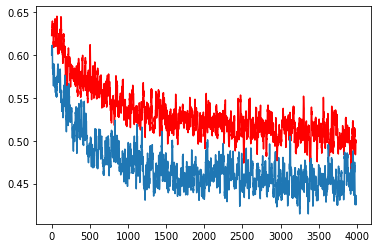

In [61]:
loss_over_time= np.loadtxt('./train_loss_xyr.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_xyr.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=10

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))

[]
k--- 0
[1.5886417600756]
k--- 1
[1.5886417600756, 1.7259717001616963]
k--- 2
[1.5886417600756, 1.7259717001616963, 1.580173813176178]
k--- 3
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183]
k--- 4
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547]
k--- 5
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547, 1.6803177684177104]
k--- 6
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547, 1.6803177684177104, 1.640152439784968]
k--- 7
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547, 1.6803177684177104, 1.640152439784968, 1.6515655076272595]
k--- 8
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547, 1.6803177684177104, 1.640152439784968, 1.6515655076272595, 1.714465756554346]
k--- 9
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.56

[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547, 1.6803177684177104, 1.640152439784968, 1.6515655076272595, 1.714465756554346, 1.583193876486023, 1.5478698127405, 1.6246366319572685, 1.8345401211357406, 1.6583640641539077, 1.6403401284562176, 1.5283814827303672, 1.6323726488533934, 1.6950985029304706, 1.613848050158872, 1.692365385990304, 1.6261176370029526, 1.6979632933292632, 1.678197882589842, 1.6295683407382553, 1.728251747695774, 1.6258907040905226, 1.69652771678439, 1.6288160459132968, 1.6553574520180063, 1.648870920334919]
k--- 30
[1.5886417600756, 1.7259717001616963, 1.580173813176178, 1.5656082341734183, 1.652782417921547, 1.6803177684177104, 1.640152439784968, 1.6515655076272595, 1.714465756554346, 1.583193876486023, 1.5478698127405, 1.6246366319572685, 1.8345401211357406, 1.6583640641539077, 1.6403401284562176, 1.5283814827303672, 1.6323726488533934, 1.6950985029304706, 1.613848050158872, 1.692365385990304, 1.6261176370029526, 1

"\n\nprint(Ad[0])\nprint(d[0])\n\n#Ad = torch.mul(Ad, d)\n\nf=Ad[0].detach().numpy()\ng=d[0].detach().numpy()\n\nprint(np.multiply(f,g))\nprint(y[0])\n\n\n\n\nAd = postprocess_2(Ad)\nprint(Ad[0])\nAd=postprocess_MinCostAss(Ad)\nprint(Ad[0])\n#torch.manual_seed(344)\n\n#Ad = torch.rand(1,3,4)\n#print(Ad[0])\n\nf=Ad[0].detach().numpy()\n\nl=np.ones(len(f))*2\nl=l.astype(int)\nf2=np.repeat(Ad[0].detach().numpy(), l, axis=0)\n\n#print('f2',f2)\n\nrow_ind, col_ind = linear_sum_assignment(1-f)\n\n#print(row_ind,col_ind)\n\nz=np.zeros(f.shape)\n\n\nfor i,j in zip(row_ind, col_ind):\n        z[i,j]=1\n\nprint(z)\n        \nf2[0::2, :] = z[:] \n        \n#print('f2',f2) \n\n\nrow_ind_f, col_ind_f = linear_sum_assignment(1-f2)\n\n\nz3=np.zeros(f2.shape)\n\n\nfor i,j in zip(row_ind_f, col_ind_f):\n        z3[i,j]=1\n\n\nprint(z3)\n\nf_add = z3[0::2, :] + z3[1::2, :]\n\nprint('f_add',f_add)\n        \nz2 = np.zeros(f.shape)\nzero_col=np.where(~z.any(axis=0))[0]\nind=torch.argmax(Ad[0][:,zero_col],

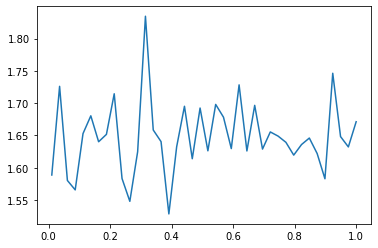

In [62]:
a=np.linspace(0.01,1,num=40)
#a=[0.1]

transformer.load_state_dict(torch.load('AttTrack24.pt'))
transformer.eval()
convert_tensor = transforms.ToTensor()
lo=[]
for k in range(len(a)):
    print(lo)
    print('k---',k)
    g=[]
    for v in range(100):
        #print('v-',v)


        src1, src2, y,d = collate_fn(1,-100,train=False)

        src1= src1.to(DEVICE)
        src2= src2.to(DEVICE)



        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)

        Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
        #print(Ad[0])

        Ad_real = complete_postprocess(Ad,d,a[k])
        #print(Ad_real[0])
        #print(y[0])
        
        Ad_real= convert_tensor(Ad_real[0])


        l = nn.CrossEntropyLoss()
        s = l(Ad_real[0], y[0])
        g.append(s)
    lo.append(np.mean(g))

plt.plot(a,lo)



'''

print(Ad[0])
print(d[0])

#Ad = torch.mul(Ad, d)

f=Ad[0].detach().numpy()
g=d[0].detach().numpy()

print(np.multiply(f,g))
print(y[0])




Ad = postprocess_2(Ad)
print(Ad[0])
Ad=postprocess_MinCostAss(Ad)
print(Ad[0])
#torch.manual_seed(344)

#Ad = torch.rand(1,3,4)
#print(Ad[0])

f=Ad[0].detach().numpy()

l=np.ones(len(f))*2
l=l.astype(int)
f2=np.repeat(Ad[0].detach().numpy(), l, axis=0)

#print('f2',f2)

row_ind, col_ind = linear_sum_assignment(1-f)

#print(row_ind,col_ind)

z=np.zeros(f.shape)


for i,j in zip(row_ind, col_ind):
        z[i,j]=1

print(z)
        
f2[0::2, :] = z[:] 
        
#print('f2',f2) 


row_ind_f, col_ind_f = linear_sum_assignment(1-f2)


z3=np.zeros(f2.shape)


for i,j in zip(row_ind_f, col_ind_f):
        z3[i,j]=1


print(z3)

f_add = z3[0::2, :] + z3[1::2, :]

print('f_add',f_add)
        
z2 = np.zeros(f.shape)
zero_col=np.where(~z.any(axis=0))[0]
ind=torch.argmax(Ad[0][:,zero_col], dim=0)
        
print(Ad[0][:,zero_col])        
print(np.where(~z.any(axis=0))[0])
print(ind)
print(z)

for k,l in zip(ind,zero_col):
    z2[k,l]=1
    
print(z+z2)    

pp_A=postprocess(Ad)




#print(pp_A[0])
'''



In [66]:
#postprocess Training


transformer = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)
transformer.load_state_dict(torch.load('AttTrack24.pt'))

NUM_EPOCHS=1000


transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0,tra_to_tens=True)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00001, betas=(0.9, 0.98), eps=1e-9)

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch_post_process(transformer, optimizer,loss_fn)
    end_time = timer()
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_pp.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]])
Epoch: 1, Train loss: 3.240, Epoch time = 2.465s
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0

tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])
Epoch: 13, Train loss: 3.561, Epoch time = 2.879s
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
Epoch: 14, Train loss: 3.536, Epoch time = 2.867s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]])
Epoch: 33, Train loss: 2.888, Epoch time = 3.073s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]])
Epoch: 64, Train loss: 3.361, Epoch time = 2.872s
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
Epoc

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 74, Train loss: 2.754, Epoch time = 2.940s
tensor([[1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])
Epoch: 75, Train loss: 3.355, Epoch time = 2.906s
tensor([[1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
Epoch

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])
Epoch: 101, Train loss: 2.783, Epoch time = 3.012s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
Epoch: 110, Train loss: 3.807, Epoch time = 2.835s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0.],


tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0.]])
Epoch: 137, Train loss: 3.246, Epoch time = 2.826s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
Epoch: 138, Train loss: 3.582, Epoch time = 2.904s
tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])
Epoch: 150, Train loss: 3.393, Epoch time = 2.823s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
Epoch: 151, Train loss: 4.033, Epoch time = 2.760s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
      

tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
Epoch: 162, Train loss: 3.293, Epoch time = 2.865s
tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
Epoch: 169, Train loss: 2.801, Epoch time = 2.960s
tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])
Epoch: 178, Train loss: 3.127, Epoch time = 2.929s
tensor([[1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1.,

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])
Epoch: 188, Train loss: 3.083, Epoch time = 2.805s
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])
Epoch: 199, Train loss: 3.047, Epoch time = 2.818s
tensor([[1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 233, Train loss: 3.749, Epoch time = 2.913s
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])
Epoch: 240, Train loss: 3.488, Epoch time = 3.028s
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])
Epoch: 241, Train loss: 3.291, Epoch time = 2.807s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]])
Epoch: 252, Train loss: 3.435, Epoch time = 2.776s
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])
Epoch: 253, Train loss: 3.716, Epoch time = 2.782s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
    

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]])
Epoch: 265, Train loss: 2.848, Epoch time = 2.814s
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])
Epoch: 276, Train loss: 2.948, Epoch time = 2.917s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
      

tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 286, Train loss: 3.540, Epoch time = 2.665s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])
Epoch: 296, Train loss: 3.365, Epoch time = 2.923s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

tensor([[1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 315, Train loss: 3.401, Epoch time = 2.921s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])
Epoch: 323, Train loss: 2.677, Epoch time = 2.744s
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])
Epoch: 324, Train loss: 2.974, Epoch time = 2.938s
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0.,

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 343, Train loss: 3.618, Epoch time = 2.845s
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 344, Train loss: 2.932, Epoch time = 2.760s
tensor([[1., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0.]])
Epoch: 349, Train loss: 3.838, Epoch time = 2.826s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])
Epoch: 356, Train loss: 3.200, Epoch time = 2.996s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]])
Epoch: 368, Train loss: 3.081, Epoch time = 2.850s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0.,

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
Epoch: 382, Train loss: 3.001, Epoch time = 3.049s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0

tensor([[1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.]])
Epoch: 393, Train loss: 3.115, Epoch time = 2.838s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      

tensor([[1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])
Epoch: 406, Train loss: 2.746, Epoch time = 2.827s
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])
Epoch: 407, Train loss: 3.017, Epoch time = 2.788s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.,

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.]])
Epoch: 418, Train loss: 3.366, Epoch time = 2.821s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.,

tensor([[1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])
Epoch: 431, Train loss: 3.198, Epoch time = 2.845s
tensor([[1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 1., 0., 0.],
    

tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0.]])
Epoch: 446, Train loss: 3.437, Epoch time = 2.931s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 465, Train loss: 3.109, Epoch time = 2.956s
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])
Epoch: 466, Train loss: 3.046, Epoch time = 2.777s
tensor([[1., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
      

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
Epoch: 478, Train loss: 3.223, Epoch time = 2.999s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],


tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
Epoch: 496, Train loss: 2.809, Epoch time = 2.833s
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
    

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 509, Train loss: 2.858, Epoch time = 2.742s
tensor([[1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.]])
Epoch: 510, Train loss: 3.077, Epoch time = 2.827s
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.]])
Epoch: 515, Train loss: 3.056, Epoch time = 2.633s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1

tensor([[1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]])
Epoch: 526, Train loss: 3.070, Epoch time = 2.915s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
Epoch: 527, Train loss: 2.971, Epoch time = 2.822s
tens

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1.,

tensor([[1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])
Epoch: 548, Train loss: 3.235, Epoch time = 2.706s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0.]])
Epoch: 558, Train loss: 3.329, Epoch time = 2.730s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])
Epoch: 574, Train loss: 3.254, Epoch time = 2.708s
tensor([[1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Epoch: 596, Train loss: 3.022, Epoch time = 2.878s
tensor([[1., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 597, Train loss: 2.710, Epoch time = 2.884s
tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
    

tensor([[1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 608, Train loss: 3.357, Epoch time = 2.693s
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 609, Train loss: 2.976, Epoch time = 2.778s
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]])
Epoch: 61

tensor([[1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]])
Epoch: 620, Train loss: 3.291, Epoch time = 2.950s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])
Epoch: 636, Train loss: 3.122, Epoch time = 2.716s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]])
Epoch: 662, Train loss: 2.730, Epoch time = 2.803s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])
Epoch: 670, Train loss: 2.998, Epoch time = 2.722s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    

tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
Epoch: 680, Train loss: 2.837, Epoch time = 2.810s
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.]])
Epoch: 687, Train loss: 3.734, Epoch time = 2.583s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])
Epoch: 726, Train loss: 2.679, Epoch time = 2.680s
tensor([[1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]])
Epoch: 734, Train loss: 3.168, Epoch time = 2.753s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]])
Epoch: 742, Train loss: 3.351, Epoch time = 2.754s
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
Epoch: 759, Train loss: 3.700, Epoch time = 2.698s
tensor([[1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])
Epoch: 760, Train loss: 2.449, Epoch time = 2.659s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0.]

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])
Epoch: 771, Train loss: 2.895, Epoch time = 2.690s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.]])
Epoch: 787, Train loss: 3.231, Epoch time = 2.765s
tensor

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
Epoch: 794, Train loss: 3.384, Epoch time = 2.773s
tensor([[1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])
Epoch: 795, Train loss: 3.125, Epoch time = 2.855s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

tensor([[1., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0.]])
Epoch: 826, Train loss: 3.482, Epoch time = 2.777s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])
Epoch: 827, Train loss: 2.999, Epoch time = 2.761s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 837, Train loss: 3.952, Epoch time = 2.761s
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
Epoch: 838, Train loss: 2.357, Epoch time = 2.736s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 864, Train loss: 2.691, Epoch time = 2.771s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 874, Train loss: 3.288, Epoch time = 2.898s
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])
Epoch: 875, Train loss: 2.944, Epoch time = 2.797s
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]])
Epoch: 883, Train loss: 3.516, Epoch time = 2.868s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.]])
Epoch: 893, Train loss: 2.730, Epoch time = 2.791s
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])
Epoch: 894, Train loss: 2.988, Epoch time = 2.731s
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])
Epoch: 927, Train loss: 3.604, Epoch time = 2.872s
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.]])
Epoch: 934, Train loss: 2.635, Epoch time = 2.698s
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0.]])
Epoch: 956, Train loss: 3.151, Epoch time = 2.763s
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])
Epoch: 957, Train loss: 3.204, Epoch time = 2.837s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
Epoch: 965, Train loss: 4.038, Epoch time = 2.653s
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0.]])
Epoch: 974, Train loss: 3.146, Epoch time = 2.756s
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0.,

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Epoch: 987, Train loss: 3.180, Epoch time = 2.669s
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0.]])
Epoch: 988, Train loss: 3.364, Epoch time = 2.773s
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0

tensor([[1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0

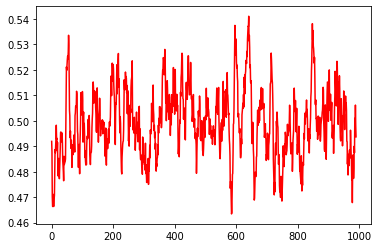

In [57]:
N=10

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')

In [10]:
#recon
run=14
src1, src2, y = collate_fn(31,-100,recon=True,train=False,run=run)

print(src1.size())
src1= src1.to(DEVICE)
src2= src2.to(DEVICE)
    
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)
    
    
#transformer.load_state_dict(torch.load('AttTrack.pt',map_location=torch.device('cpu')))
transformer.eval()    
    

Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)

Ad = postprocess_2(Ad)
pp_A=postprocess_MinCostAss(Ad)
#pp_A=postprocess_linAss(Ad)

print('y',y[0])
print('Ad',Ad[0])
print('pp',pp_A[0])

for i in range(5):
    print(pp_A[i])
    
    
make_reconstructed_edgelist(pp_A,run=run)

recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon


ValueError: too many values to unpack (expected 3)

In [ ]:


x=np.arange(1,51,dtype=int)
y=np.arange(1,7,dtype=int)

l=[]
for i in range(5):
    z=np.random.choice(x, replace=False)
    l.append(z)
print(l)
s=np.random.random_integers(12)
print(s)
s=np.random.random_integers(12)
print(s)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)

print(out.shape)

In [ ]:
im = Image.open('/home/mo/Desktop/IWR/CellTracking/Fluo-C2DL-Huh7/02_GT/TRA/man_track001.tif')
im.show()

print(np.array(im))

In [ ]:
print(stop)

In [ ]:
p_drop=0.05
learning_rate=0.0001 #0.001 for cnn
epochs = 2000
emb_size=6   #!!!!!!!!!!!!!!!!!!!!
seq_length=104
d_m=12*20
nhead= 3
num_encoder_layers=4

model = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)


#model=MiniLin(ch_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[250,750,1000,1500,2000,2500], gamma=0.5)


loss_function = nn.MSELoss(reduction='sum')

#loss_function = myL_loss(100,100)


model, loss_over_time, test_error = train_easy(model, optimizer, loss_function, epochs, scheduler,verbose=True,eval=True)

In [ ]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
PAD_IDX=0



a = torch.ones(5, 6)*2
b = torch.ones(2, 6)
c = torch.ones(4, 6)
c2 = torch.ones(4, 6)/2

print(c)
print(c2)


#torch.matmul(d, e) 




d = pad_sequence([a, c])
e = pad_sequence([b, c2])




#print(d.size(),e.size())
#print('d',d[:,1,:],d[:,1,:].size())

mask1=create_mask(d,PAD_IDX)
mask2=create_mask(e,PAD_IDX)


d=torch.transpose(d,0,1)
e=torch.transpose(e,0,1)
e=torch.transpose(e,1,2)

#print('d2',d,d.size(),d[1,:,:])
#print('e2',e,e.size(),e[1,:,:])


#d=torch.reshape(d, (d.size(1), d.size(0), d.size(2)))
#e=torch.reshape(e, (e.size(1), e.size(2), e.size(0)))


#print(d,d.size())
#print('e',e,e.size(),e[0,:,:])



z=torch.bmm(d,e)

#print(z[0],z[1])
print(mask1[1],mask2[1])

#model = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)

#out=model(d,e,mask1,mask2)
#print(out.size())


mA=makeAdja()
Ad=mA.forward(z,mask1,mask2)

print(Ad.size())

In [ ]:
print(stop)

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U torchdata
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        print('PE',token_embedding.size(),self.pos_embedding[:token_embedding.size(0), :].size())
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        
        #print('trans_src_before_pos',src,src.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        print('trans_src',src_emb,src_emb.size())
        print('trans_src_padd',src_padding_mask,src_padding_mask.size())
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        print('outs',outs.size())
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    print('src_size',src.size())
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    #print('batch',len(batch),batch)
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        #print('src_sample',src_sample)
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        #print('emb',src_batch[-1])
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
        
    #print('src_batch',src_batch)
    #print('src_batch s',len(src_batch))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        
        
        #print('trainsrc',src,src.size())

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        #print('trainsrc_padd',src_padding_mask,src_padding_mask.size())

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))